In [1]:
pip install python-box


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 31.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Импортируем библиотеки 
import pprint
import ast
import random
import time
import json
import os
import cv2

import torch
import timm
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import albumentations as A
from  albumentations.pytorch.transforms import ToTensorV2
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from box import Box
from tqdm import tqdm


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Прочитаем датафрейм и конвертируем фиче в правильный для нас вид 
df = pd.read_csv('/kaggle/input/freihand-32000-first/data_new.csv')

xy_points_list = []
for i, row in df.iterrows():
    cleaned_str = [int(i) for i in row['xy_points'].replace('\n', ',').replace('[', ' ').replace(']', ' ').replace(',', ' ').split()]
    uv = [cleaned_str[i:i+2] for i in range(0, len(cleaned_str), 2)]
    xy_points_list.append(uv)

    
df['xy'] = xy_points_list
df.head()

,Unnamed: 0,path_to_img,xy_points,xy
0,0,/kaggle/input/freihand-32000-first/FreiHAND_pp...,[[131 93]\n [115 84]\n [105 84]\n [ 94 93]...,"[[131, 93], [115, 84], [105, 84], [94, 93], [7..."
1,1,/kaggle/input/freihand-32000-first/FreiHAND_pp...,[[ 81 99]\n [100 102]\n [114 96]\n [126 91]...,"[[81, 99], [100, 102], [114, 96], [126, 91], [..."
2,2,/kaggle/input/freihand-32000-first/FreiHAND_pp...,[[ 74 141]\n [ 66 144]\n [ 61 147]\n [ 70 153]...,"[[74, 141], [66, 144], [61, 147], [70, 153], [..."
3,3,/kaggle/input/freihand-32000-first/FreiHAND_pp...,[[132 145]\n [114 137]\n [102 132]\n [ 92 125]...,"[[132, 145], [114, 137], [102, 132], [92, 125]..."
4,4,/kaggle/input/freihand-32000-first/FreiHAND_pp...,[[102 150]\n [121 137]\n [135 126]\n [139 113]...,"[[102, 150], [121, 137], [135, 126], [139, 113..."


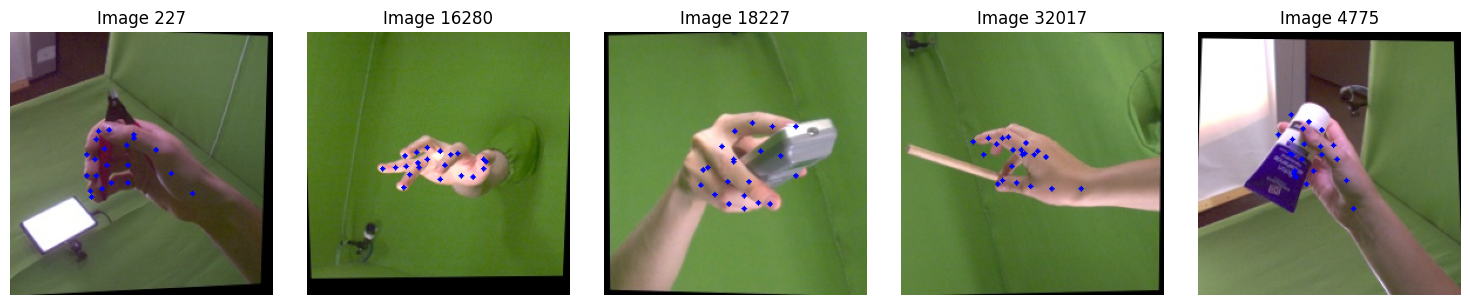

In [5]:
# Отобразим случайне изображения из данных c якорными точками 
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
titles = []

for i, (ax) in enumerate(axes):
    index = random.randint(0, len(df))
    row  = df.iloc[index,]
    titles.append(f"Image {index}")
    path_to_img = os.path.join(row.path_to_img)
    image = cv2.imread(path_to_img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    xy = row.xy
    for point in xy:
        img = cv2.circle(image, point, 2, (0,0,255), -1)

    ax.imshow(img)
    ax.set_title(titles[i])
    ax.axis('off')


plt.tight_layout()
plt.show()

In [6]:
# Cоздадим конфиг для обучения модели
config = Box()

config.num_workers = os.cpu_count()
config.batch_size = 64
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.seed = 1771
config.model_name = 'tf_efficientnetv2_s_in21k'
config.num_features = 42
config.optimizer_lr = 0.0001
config.epochs = 15
config.test_size = 0.4

In [7]:
# Фиксируем сид для воспроизведения эксперимента в дальнейшем 
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

    print(f'Set seed: {seed}')
    
set_seed(seed=config.seed)

Set seed: 1771


In [8]:
# Напишем датаcэт для наших данных 
class HandDataset(Dataset):
    def __init__(self, df, size, is_train, demo=False):
        self.df = df
        self.demo = demo
        self.size = size
        if is_train:
            self.transform = A.Compose([
            A.Resize(height=size, width=size, always_apply=True),
            A.Rotate([-90,90], p=1),
            A.ShiftScaleRotate(shift_limit=0.3, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=1.0),
            A.Flip(p=0.5),
            A.ColorJitter(p=0.5),
            A.ChannelShuffle (p=0.5),
            A.CLAHE(p=0.5),
            A.GaussNoise(p=0.5),
            A.RandomSnow(p=0.15),
            A.RandomRain(p=0.15),
            A.GaussianBlur(blur_limit=(3, 7), p=0.5),
            A.Normalize(p=1),
                
            ToTensorV2()],
            keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
            
        else:
            self.transform = A.Compose([
            A.Resize(width=size, height=size, p=1.0),
            A.Normalize(p=1),
            ToTensorV2()],
            keypoint_params=A.KeypointParams(format='xy'))
            
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        image_path, json_path = row['path_to_img'], row['xy']
        image = cv2.imread(image_path)
        
        
        hand_pts = row['xy']
        transformed = self.transform(image=image, keypoints=hand_pts)
        transformed_image = transformed['image']
        transformed_hand_pts = transformed['keypoints']
        
        # Удаляю все точки, которые вышли за рамки нашего кропа. 
        for el in range(len(transformed_hand_pts)):
            if min(transformed_hand_pts[el]) < 0 or max(transformed_hand_pts[el]) >= self.size: 
                transformed_hand_pts[el] = [0., 0.]
            else:
                transformed_hand_pts[el] = [transformed_hand_pts[el][0] / self.size, transformed_hand_pts[el][1] / self.size]
                 
             
        target = torch.tensor([item for sublist in transformed_hand_pts for item in sublist])

        return (transformed_image.float(), target)
        
        
            
            

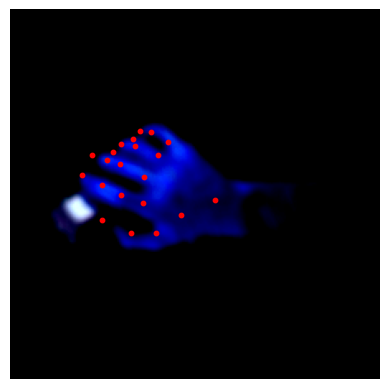

In [9]:
# Проверка работы аугментаций

dataset = HandDataset(df, 224, True, True)

# r_img_V, target  = dataset[random.randint(0, len(dataset))]
r_img_V, target  = dataset[177]
target_upd = (target * 224 // 1).detach().cpu().numpy()
uv = np.array([target_upd[i:i+2] for i in range(0, len(target_upd), 2)])
r_img_V_np = r_img_V.numpy()

plt.imshow(np.transpose(r_img_V_np, (1, 2, 0)))
plt.scatter(uv[:, 0], uv[:, 1], color='red', s=10)
plt.axis('off') 
plt.show()

In [10]:
# Разобьем наши данные на тест и трейн. cоздадим тренеровочный и тестовый датасэт и даталоадэры
train_df, val_df = train_test_split(df, 
                                    test_size=config.test_size,
                                    random_state=config.seed)
dataset_train = HandDataset(train_df.reset_index(), 224, True)
dataset_test = HandDataset(val_df.reset_index(), 224, True)

train_loader = DataLoader(dataset_train,
                          batch_size=config.batch_size,
                          shuffle=True,
                         num_workers=config.num_workers
                         )
valid_loader = DataLoader(dataset_test,
                          batch_size=config.batch_size,
                         num_workers=config.num_workers
                         )

In [11]:
# Возьмем предобученную модель и перепишем классификатор 
model_name = config.model_name
model = timm.create_model(model_name, pretrained=True).to(config.device)

model
additional_layers = nn.Sequential(
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU()
)
model.classifier = nn.Sequential(
    nn.Linear(256, config.num_features)
)

model.classifier = nn.Sequential(additional_layers, model.classifier)
model.to(config.device)

config.device

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_s_21k-6337ad01.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnetv2_s_21k-6337ad01.pth


device(type='cuda')

In [12]:
loss_f = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=config.optimizer_lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

In [13]:
# Проведем обучение модели. Для корректной работы и для защиты от сбоев будем сохранять модель после каждой эпохи
for epoch_i in range(1, config.epochs + 1):
    start = time.time()

    print(f'---------------------epoch:{epoch_i}/{config.epochs}---------------------')

    # loss
    avg_train_loss = 0
    avg_val_loss = 0
    predicted_labels_list = None
    true_labels_list = None

    ############## Train #############
    model.train()
    train_pbar = tqdm(train_loader, desc="Training")
    for X,y in (train_pbar):
        X_batch = X.to(config.device)
        y_batch = y.to(config.device)

        optimizer.zero_grad()
        res = model.forward(X_batch)
    
        loss = loss_f(res.float(), y_batch.float())

        if torch.cuda.is_available():
            train_pbar.set_postfix(gpu_load=f"{torch.cuda.memory_allocated() / 1024 ** 3:.2f}GB",
                                   loss=f"{loss.item():.4f}")
        else:
            train_pbar.set_postfix(loss=f"{loss.item():.4f}")

        loss.backward()
        optimizer.step()
        
        avg_train_loss += loss * len(y_batch)
        del X, res
        

    
    ########## VALIDATION ###############
    model.eval()
    valid_pbar = tqdm(valid_loader, desc="Testing")
    with torch.no_grad():
        for X,y in (valid_pbar):
            X_batch = X.to(config.device)
            y_batch = y.to(config.device)

            res = model.forward(X_batch)
            
            loss = loss_f(res.float(), y_batch.float())
            avg_val_loss += loss * len(y_batch)
            valid_pbar.set_postfix(loss=f"{loss.item():.4f}")

            res = res.detach().cpu().numpy()
            y_batch = y_batch.cpu().numpy()
            if predicted_labels_list is None:
                predicted_labels_list = res
                true_labels_list = y_batch
            else:
                predicted_labels_list = np.concatenate([predicted_labels_list, res], axis=0)
                true_labels_list = np.concatenate([true_labels_list, y_batch], axis=0)

            del X, res
            

    torch.cuda.empty_cache()

    avg_train_loss = avg_train_loss / len(dataset_train)
    avg_val_loss = avg_val_loss / len(dataset_test)

    all_predicted_labels = np.vstack(predicted_labels_list)
    all_true_labels = np.vstack(true_labels_list)
    all_true_labels = np.squeeze(all_true_labels)

    
    mae_per_output = np.mean(np.abs(all_true_labels - all_predicted_labels), axis=0)
    mean_mae = np.mean(mae_per_output)
    print(f'epoch: {epoch_i}, lr_rate {optimizer.param_groups[0]["lr"]}')

    print("loss_train: %0.4f| loss_valid: %0.4f|" % (avg_train_loss, avg_val_loss))
    print(f"metric {mean_mae:.<5g}")

    elapsed_time = time.time() - start
    hours = int(elapsed_time // 3600)
    minutes = int((elapsed_time % 3600) // 60)
    seconds = int(elapsed_time % 60)
    print(f"Elapsed time: {hours:02d}:{minutes:02d}:{seconds:02d}")
    scheduler.step()
    torch.save(model, f"model_ep_{epoch_i}.pt")

---------------------epoch:1/15---------------------


Testing: 100%|██████████| 204/204 [02:32<00:00,  1.33it/s, loss=0.0113]


epoch: 1, lr_rate 0.0001
loss_train: 0.0237| loss_valid: 0.0105|
metric 0.0789009
Elapsed time: 00:06:52
---------------------epoch:2/15---------------------


Testing: 100%|██████████| 204/204 [02:07<00:00,  1.60it/s, loss=0.0066]


epoch: 2, lr_rate 0.0001
loss_train: 0.0083| loss_valid: 0.0069|
metric 0.0608146
Elapsed time: 00:05:33
---------------------epoch:3/15---------------------


Testing: 100%|██████████| 204/204 [02:00<00:00,  1.70it/s, loss=0.0055]


epoch: 3, lr_rate 0.0001
loss_train: 0.0063| loss_valid: 0.0057|
metric 0.0536929
Elapsed time: 00:05:22
---------------------epoch:4/15---------------------


Testing: 100%|██████████| 204/204 [02:03<00:00,  1.65it/s, loss=0.0030]


epoch: 4, lr_rate 8e-05
loss_train: 0.0051| loss_valid: 0.0045|
metric 0.0449779
Elapsed time: 00:05:28
---------------------epoch:5/15---------------------


Testing: 100%|██████████| 204/204 [02:02<00:00,  1.66it/s, loss=0.0076]


epoch: 5, lr_rate 8e-05
loss_train: 0.0044| loss_valid: 0.0040|
metric 0.0418145
Elapsed time: 00:05:30
---------------------epoch:6/15---------------------


Testing: 100%|██████████| 204/204 [02:06<00:00,  1.62it/s, loss=0.0035]


epoch: 6, lr_rate 8e-05
loss_train: 0.0040| loss_valid: 0.0037|
metric 0.0396104
Elapsed time: 00:05:31
---------------------epoch:7/15---------------------


Testing: 100%|██████████| 204/204 [02:02<00:00,  1.66it/s, loss=0.0044]


epoch: 7, lr_rate 6.400000000000001e-05
loss_train: 0.0037| loss_valid: 0.0034|
metric 0.0379454
Elapsed time: 00:05:29
---------------------epoch:8/15---------------------


Testing: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s, loss=0.0031]


epoch: 8, lr_rate 6.400000000000001e-05
loss_train: 0.0034| loss_valid: 0.0032|
metric 0.0354748
Elapsed time: 00:05:26
---------------------epoch:9/15---------------------


Testing: 100%|██████████| 204/204 [02:01<00:00,  1.68it/s, loss=0.0034]


epoch: 9, lr_rate 6.400000000000001e-05
loss_train: 0.0033| loss_valid: 0.0031|
metric 0.035181
Elapsed time: 00:05:26
---------------------epoch:10/15---------------------


Testing: 100%|██████████| 204/204 [02:03<00:00,  1.65it/s, loss=0.0037]


epoch: 10, lr_rate 5.120000000000001e-05
loss_train: 0.0031| loss_valid: 0.0030|
metric 0.0341858
Elapsed time: 00:05:29
---------------------epoch:11/15---------------------


Testing: 100%|██████████| 204/204 [02:04<00:00,  1.64it/s, loss=0.0022]


epoch: 11, lr_rate 5.120000000000001e-05
loss_train: 0.0030| loss_valid: 0.0029|
metric 0.0335345
Elapsed time: 00:05:32
---------------------epoch:12/15---------------------


Testing: 100%|██████████| 204/204 [01:59<00:00,  1.70it/s, loss=0.0040]


epoch: 12, lr_rate 5.120000000000001e-05
loss_train: 0.0029| loss_valid: 0.0028|
metric 0.0328768
Elapsed time: 00:05:24
---------------------epoch:13/15---------------------


Testing: 100%|██████████| 204/204 [02:04<00:00,  1.64it/s, loss=0.0030]


epoch: 13, lr_rate 4.0960000000000014e-05
loss_train: 0.0028| loss_valid: 0.0027|
metric 0.0321557
Elapsed time: 00:05:33
---------------------epoch:14/15---------------------


Testing: 100%|██████████| 204/204 [02:04<00:00,  1.64it/s, loss=0.0050]


epoch: 14, lr_rate 4.0960000000000014e-05
loss_train: 0.0027| loss_valid: 0.0026|
metric 0.0311354
Elapsed time: 00:05:28
---------------------epoch:15/15---------------------


Testing: 100%|██████████| 204/204 [02:02<00:00,  1.66it/s, loss=0.0030]


epoch: 15, lr_rate 4.0960000000000014e-05
loss_train: 0.0027| loss_valid: 0.0026|
metric 0.0318066
Elapsed time: 00:05:29


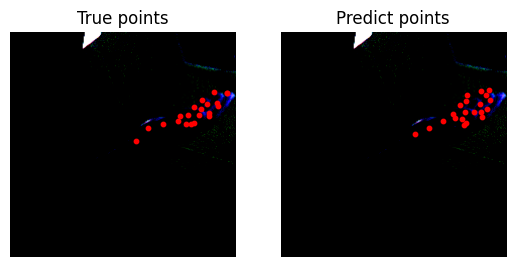

In [14]:
# Проверим работу нашей модели 

r_img_V, target, = dataset_test[random.randint(0,len(dataset_test))]

target_upd = target * 224 // 1
target_upd = target_upd.detach().cpu().numpy()
uv = np.array([target_upd[i:i+2] for i in range(0, len(target_upd), 2)])
model.to('cpu')

pred = model.forward(r_img_V.unsqueeze(0))[0] * 224 // 1
pred = pred.detach().cpu().numpy()
pred_xy = np.array([pred[i:i+2] for i in range(0, len(pred), 2)])

r_img_V_np = r_img_V.numpy()

fig, axs = plt.subplots(1, 2)

# Отображение первой картинки
axs[0].imshow(np.transpose(r_img_V_np, (1, 2, 0)))
axs[0].scatter(uv[:, 0], uv[:, 1], color='red', s=10)
axs[0].axis('off')
axs[0].set_title('True points')
# Отображение второй картинки
axs[1].imshow(np.transpose(r_img_V_np, (1, 2, 0)))
axs[1].scatter(pred_xy[:, 0], pred_xy[:, 1], color='red', s=10)
axs[1].axis('off')
axs[1].set_title('Predict points')

# Показать график
plt.show()



In [15]:
# Проверим работу нашей модели на фото с вебкамеры 
!gdown --id  1hIL8qXT6AfcycSG2UqtsmGQY89SYy850
!gdown --id 15ne89XXtiNp6U9GLmflBJ4DNNeu3NRWK
!gdown --id 1xVKjBOpxVXI9jaxK9GBOFS0VVEAGqRIJ
!gdown --id 1l0eotEZiogvpSyGdroqHus_U77aS2CFU

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hIL8qXT6AfcycSG2UqtsmGQY89SYy850
To: /kaggle/working/WIN_20230518_16_57_06_Pro.jpg
100%|███████████████████████████████████████| 80.5k/80.5k [00:00<00:00, 678kB/s]
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15ne89XXtiNp6U9GLmflBJ4DNNeu3NRWK
To: /kaggle/working/WIN_20230518_16_56_26_Pro.jpg
100%|███████████████████████████████████████| 81.3k/81.3k [00:00<00:00, 694kB/s]
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be rem

In [16]:
def preproccesing_img(img_path):
    transform = A.Compose([
                A.Resize(width=224, height=224, p=1.0),
                A.Normalize(p=1),
                ToTensorV2()])


    image = cv2.imread(img_path)
    transform_image = transform(image = image)["image"]
    return transform_image
    

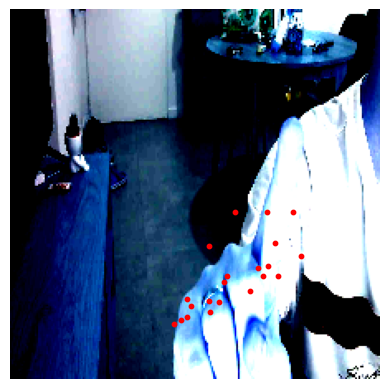

In [17]:
img_to_predict = preproccesing_img("/kaggle/working/WIN_20230518_16_56_48_Pro.jpg")
pred = model.forward(img_to_predict.unsqueeze(0))[0] * 224 // 1
pred = pred.detach().cpu().numpy()
pred_xy = np.array([pred[i:i+2] for i in range(0, len(pred), 2)])

r_img_V_np = img_to_predict.numpy()

plt.imshow(np.transpose(img_to_predict, (1, 2, 0)))
plt.scatter(pred_xy[:, 0], pred_xy[:, 1], color='red', s=10)
plt.axis('off') 
plt.show()




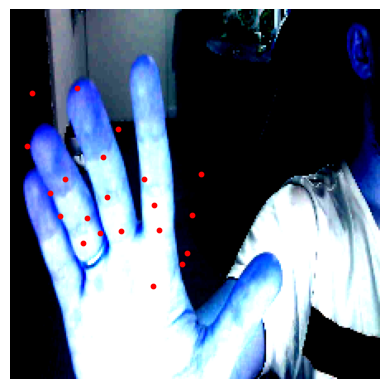

In [18]:
img_to_predict = preproccesing_img("/kaggle/working/WIN_20230518_16_57_06_Pro.jpg")
pred = model.forward(img_to_predict.unsqueeze(0))[0] * 224 // 1
pred = pred.detach().cpu().numpy()
pred_xy = np.array([pred[i:i+2] for i in range(0, len(pred), 2)])

r_img_V_np = img_to_predict.numpy()

plt.imshow(np.transpose(img_to_predict, (1, 2, 0)))
plt.scatter(pred_xy[:, 0], pred_xy[:, 1], color='red', s=10)
plt.axis('off') 
plt.show()




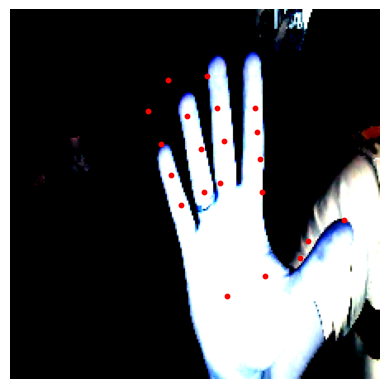

In [19]:
img_to_predict = preproccesing_img("/kaggle/working/WIN_20230518_16_56_26_Pro.jpg")
pred = model.forward(img_to_predict.unsqueeze(0))[0] * 224 // 1
pred = pred.detach().cpu().numpy()
pred_xy = np.array([pred[i:i+2] for i in range(0, len(pred), 2)])

r_img_V_np = img_to_predict.numpy()

plt.imshow(np.transpose(img_to_predict, (1, 2, 0)))
plt.scatter(pred_xy[:, 0], pred_xy[:, 1], color='red', s=10)
plt.axis('off') 
plt.show()




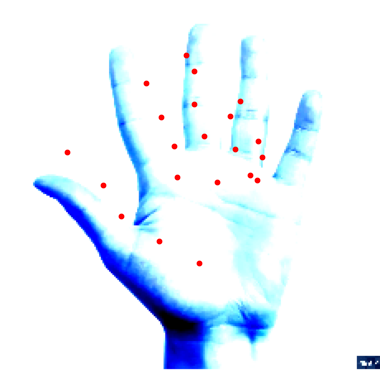

In [20]:
img_to_predict = preproccesing_img("/kaggle/working/Screenshot_4.jpg")
pred = model.forward(img_to_predict.unsqueeze(0))[0] * 224 // 1
pred = pred.detach().cpu().numpy()
pred_xy = np.array([pred[i:i+2] for i in range(0, len(pred), 2)])

r_img_V_np = img_to_predict.numpy()

plt.imshow(np.transpose(img_to_predict, (1, 2, 0)))
plt.scatter(pred_xy[:, 0], pred_xy[:, 1], color='red', s=10)
plt.axis('off') 
plt.show()